# Logistic Regression (Credit Data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import axes3d

import sklearn.linear_model as skl_lm
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

## 1. Load Datasets

In [2]:
# Load Advertising dataset
cr_data = pd.read_csv('./data/Credit.csv', index_col=0)
cr_data.head(3)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580


In [3]:
# data 정보 확인
cr_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Income     400 non-null    float64
 1   Limit      400 non-null    int64  
 2   Rating     400 non-null    int64  
 3   Cards      400 non-null    int64  
 4   Age        400 non-null    int64  
 5   Education  400 non-null    int64  
 6   Gender     400 non-null    object 
 7   Student    400 non-null    object 
 8   Married    400 non-null    object 
 9   Ethnicity  400 non-null    object 
 10  Balance    400 non-null    int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 37.5+ KB


## 2. EDA

In [4]:
# data 통계치 확인
cr_data.describe()

,Income,Limit,Rating,Cards,Age,Education,Balance
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,45.218885,4735.600000,354.940000,2.957500,55.667500,13.450000,520.015000
std,35.244273,2308.198848,154.724143,1.371275,17.249807,3.125207,459.758877
min,10.354000,855.000000,93.000000,1.000000,23.000000,5.000000,0.000000
25%,21.007250,3088.000000,247.250000,2.000000,41.750000,11.000000,68.750000
50%,33.115500,4622.500000,344.000000,3.000000,56.000000,14.000000,459.500000
75%,57.470750,5872.750000,437.250000,4.000000,70.000000,16.000000,863.000000
max,186.634000,13913.000000,982.000000,9.000000,98.000000,20.000000,1999.000000


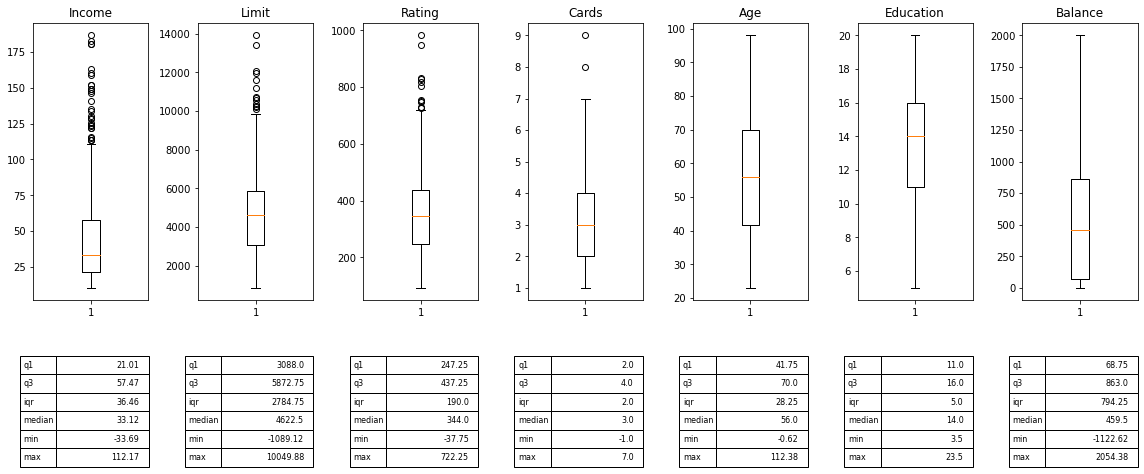

In [16]:
# IQR 관련 값을 주는 함수
def _get_iqr(data):
    """
    :param data: (Series) IQR 계산할 데이터
    :return: (dict) Q1, Q3, IQR, Median, Min, Max 값
    """
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    res = {'q1': q1, 'q3': q3, 'iqr': iqr, 'median': data.median(),
           'min': q1 - (1.5 * iqr), 'max': q3 + (1.5 * iqr)}
    res = {k: round(v, 2) for k, v in res.items()}
    return res

# 박스플롯을 그려주는 함수
def show_box(df, cols):
    """
    :param df: (DataFrame) 박스플롯을 그릴 데이터
    :param cols: (list[str]) 박스플롯을 그릴 데이터의 칼럼들 (수치형 데이터)
    :return: None
    """
    # 연속형 변수 박스플롯 그리기
    fig, axs = plt.subplots(1, len(cols), figsize=[16, 8])
    for i, col in enumerate(cols):
        # 박스플롯 그리기
        axs[i].boxplot(df.loc[:, col])
        axs[i].set_title(col)

        # 테이블 그리기
        iqr_dict = _get_iqr(df[col])
        t = axs[i].table(np.array(list(iqr_dict.values())).reshape(-1, 1),
                         rowLabels=list(iqr_dict.keys()),
                         bbox=[0.2, -0.6, 0.8, 0.4])
        # 테이블 폰트 사이즈 조정
        t.auto_set_font_size(False)
        t.set_fontsize(8)

    fig.tight_layout()
    plt.show()

# 연속형 변수 컬럼
qlt_cols = ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Balance']
show_box(cr_data, qlt_cols)

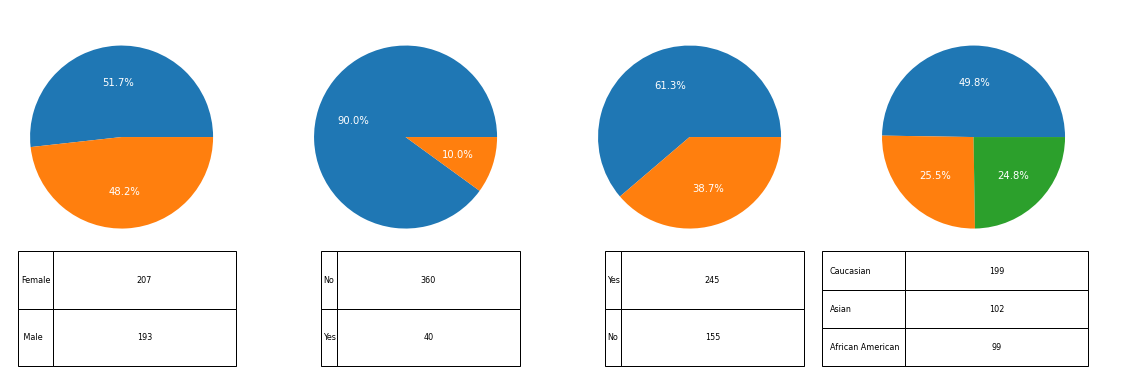

In [17]:
# 파이차트를 그려주는 함수
def show_pie(df, cols, reverse_color=False):
    """
    :param df: (DataFrame) 파이차트를 그릴 데이터
    :param cols: (list[str]) 파이차트를 그릴 데이터의 칼럼들 (수치형 데이터)
    :param reverse_color: (bool) 제목, 라벨, 수치 컬러를 화이트로 할지 여부
    :return: None
    """
    # 범주형 변수 파이차트 그리기
    fig, axs = plt.subplots(1, len(cols), figsize=[16, 8])
    for i, col in enumerate(cols):
        # 카테고리별 개수 내림차순 정렬
        grp_df = df.groupby(by=col).size().sort_values(ascending=False)

        # 파이차트 그리기
        axs[i].pie(grp_df,
                   autopct='%.1f%%',
                   labels=grp_df.index,
                   textprops={'color': "w" if reverse_color is True else 'black'})
        axs[i].set_title(col, color='w' if reverse_color is True else 'black')

        # 테이블 그리기
        t = axs[i].table(np.array(grp_df.values.tolist()).reshape(-1, 1),
                         rowLabels=grp_df.index,
                         bbox=[0.2, -0.5, 0.8, 0.5],
                         cellLoc='center')
        # 테이블 폰트 사이즈 조정
        t.auto_set_font_size(False)
        t.set_fontsize(8)

    fig.tight_layout()
    plt.show()

# 범주형 변수 칼럼
qtt_cols = ['Gender', 'Student', 'Married', 'Ethnicity']
show_pie(cr_data, qtt_cols, reverse_color=True)

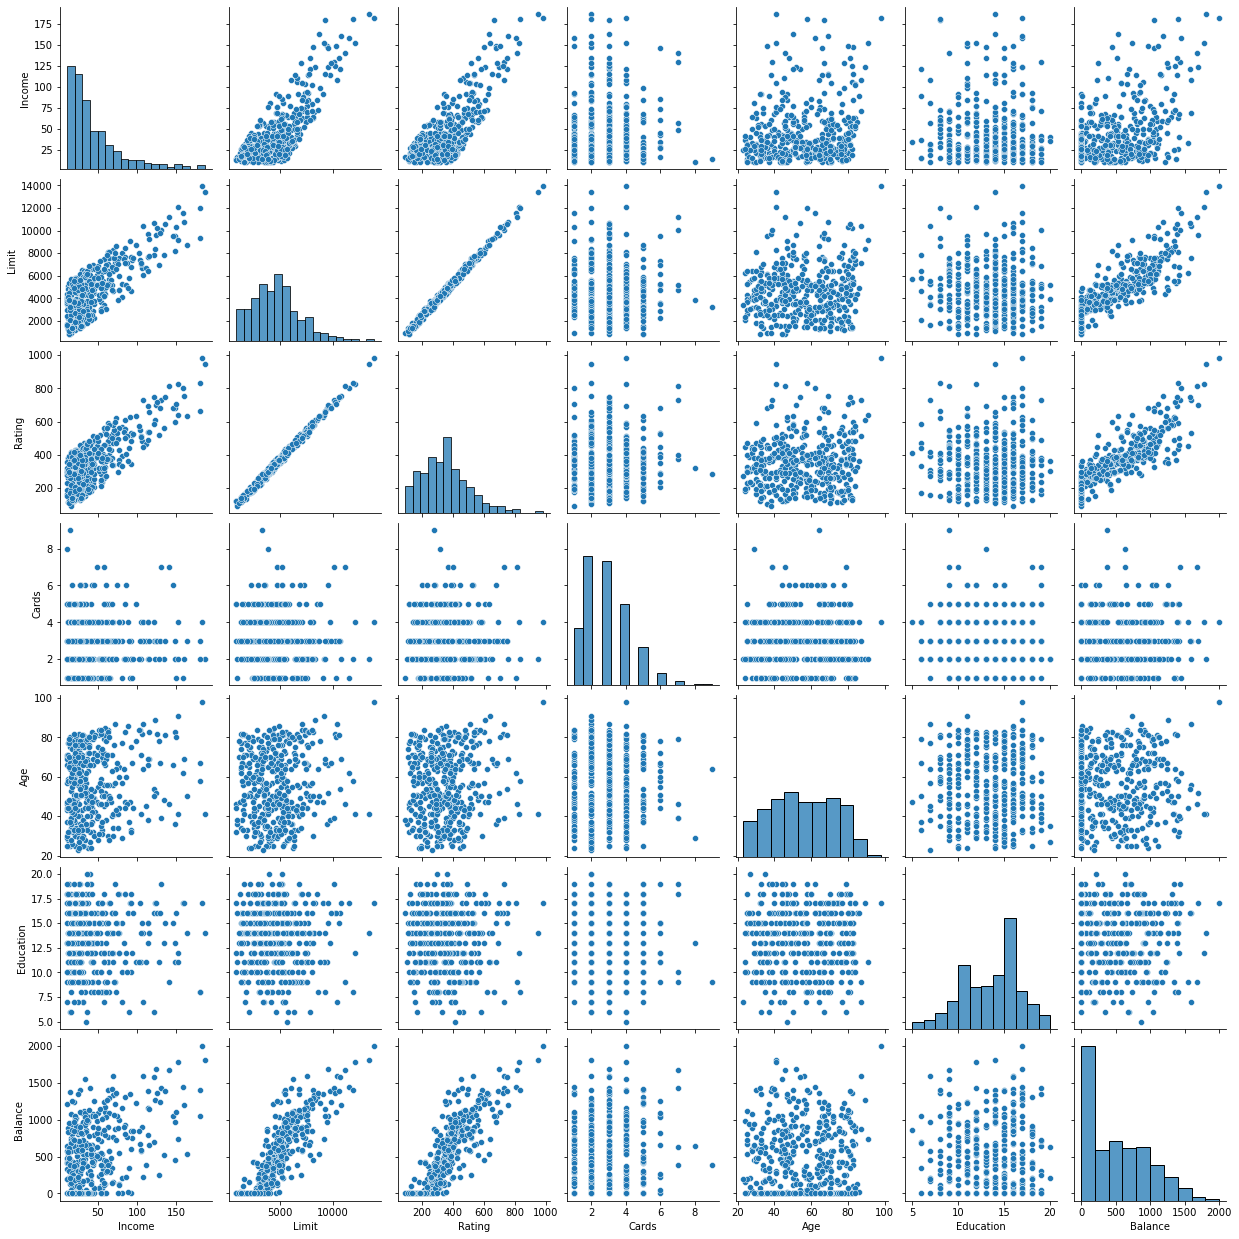

In [7]:
# data 특성을 pairplot으로 간단히 확인
sns.pairplot(cr_data[qlt_cols])

In [8]:
# 변수간 상관관계 파악
cr_data.corr()

,Income,Limit,Rating,Cards,Age,Education,Balance
Income,1.000000,0.792088,0.791378,-0.018273,0.175338,-0.027692,0.463656
Limit,0.792088,1.000000,0.996880,0.010231,0.100888,-0.023549,0.861697
Rating,0.791378,0.996880,1.000000,0.053239,0.103165,-0.030136,0.863625
Cards,-0.018273,0.010231,0.053239,1.000000,0.042948,-0.051084,0.086456
Age,0.175338,0.100888,0.103165,0.042948,1.000000,0.003619,0.001835
Education,-0.027692,-0.023549,-0.030136,-0.051084,0.003619,1.000000,-0.008062
Balance,0.463656,0.861697,0.863625,0.086456,0.001835,-0.008062,1.000000


## 3. PreProcessing

In [9]:
# IQR 이상치 제거
q1, q3 = np.percentile(cr_data['Income'], [25, 75])
iqr = q3 - q1
down_bound = q1 - (1.5 * iqr)
up_bound = q3 + (1.5 * iqr)
print(q1, q3)
print(iqr)
print(down_bound, up_bound)

21.00725 57.47075000000001
36.46350000000001
-33.68800000000002 112.16600000000003


In [10]:
# 더미 데이터
pd.get_dummies(cr_data)

,Income,Limit,Rating,Cards,Age,Education,Balance,Gender_ Male,Gender_Female,Student_No,Student_Yes,Married_No,Married_Yes,Ethnicity_African American,Ethnicity_Asian,Ethnicity_Caucasian
1,14.891,3606,283,2,34,11,333,1,0,1,0,0,1,0,0,1
2,106.025,6645,483,3,82,15,903,0,1,0,1,0,1,0,1,0
3,104.593,7075,514,4,71,11,580,1,0,1,0,1,0,0,1,0
4,148.924,9504,681,3,36,11,964,0,1,1,0,1,0,0,1,0
5,55.882,4897,357,2,68,16,331,1,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,12.096,4100,307,3,32,13,560,1,0,1,0,0,1,0,0,1
397,13.364,3838,296,5,65,17,480,1,0,1,0,1,0,1,0,0
398,57.872,4171,321,5,67,12,138,0,1,1,0,0,1,0,0,1
399,37.728,2525,192,1,44,13,0,1,0,1,0,0,1,0,0,1


## 4. Logistic Regression

----